In [1]:
import numpy as np
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from helpers import preprocess, evaluate, select_params

%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

# Chapter IV - Fit Machine Learning Models
Perform feature engineering on the combined training & test dataset before fitting machine learning models.

In [2]:
processed_df, features = preprocess("input/train.csv", "input/test.csv")
print("Selected features: ", features)
print(processed_df.shape)
processed_df.head()

Index(['PassengerId', 'Age', 'Room', 'Fare', 'Parch', 'Pclass', 'SibSp',
       'Survived', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_U', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',
       'Sex_female', 'Sex_male'],
      dtype='object')
Number of passengers with age data: 1046
Number of passengers with no age data: 263
Selected features:  ['Room', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Sex_female', 'Sex_male']
(1309, 29)


,PassengerId,Age,Room,Fare,Parch,Pclass,SibSp,Survived,Deck_A,Deck_B,...,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male,Predicted_Age,Name
0,1,22.0,49.615917,7.2500,0,3,1,0.0,0,0,...,1,0,0,1,0,0,0,1,22.0,"Braund, Mr. Owen Harris"
1,2,38.0,85.000000,71.2833,0,1,1,1.0,0,0,...,0,0,0,0,1,0,1,0,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,3,26.0,49.615917,7.9250,0,3,0,1.0,0,0,...,1,0,1,0,0,0,1,0,26.0,"Heikkinen, Miss. Laina"
3,4,35.0,123.000000,53.1000,0,1,1,1.0,0,0,...,1,0,0,0,1,0,1,0,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,5,35.0,49.615917,8.0500,0,3,0,0.0,0,0,...,1,0,0,1,0,0,0,1,35.0,"Allen, Mr. William Henry"


In [3]:
train_df = processed_df[processed_df.Survived.notnull()]
test_df = processed_df[processed_df['Survived'].isnull()]
print("Dimension of training data: %s" %str(train_df.shape))
print("Dimension of test data: %s" %str(test_df.shape))

Dimension of training data: (891, 29)
Dimension of test data: (418, 29)


Split the full dataset with all selected features well prepared.

Normalize the passengers' name by removing the quotation mark

In [4]:
test_df["cleaned_name"] = test_df["Name"].apply(lambda name: name.replace('\"', ''))
ground_truth_df = pd.read_csv("input/ground-truth.csv")
ground_truth_df["cleaned_name"] = ground_truth_df["name"].apply(lambda name: name.replace('\"', ''))
test_df = pd.merge(test_df, ground_truth_df[["cleaned_name", "age", "survived"]], how="left",
                   left_on=["cleaned_name", "Age"], right_on=["cleaned_name", "age"])
test_df = test_df.rename(columns={"survived": "Ground_Truth"})
test_df.head()

,PassengerId,Age,Room,Fare,Parch,Pclass,SibSp,Survived,Deck_A,Deck_B,...,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male,Predicted_Age,Name,cleaned_name,age,Ground_Truth
0,892,34.5,49.615917,7.8292,0,3,0,NaN,0,0,...,1,0,0,0,1,34.5,"Kelly, Mr. James","Kelly, Mr. James",34.5,0
1,893,47.0,49.615917,7.0000,0,3,1,NaN,0,0,...,0,1,0,1,0,47.0,"Wilkes, Mrs. James (Ellen Needs)","Wilkes, Mrs. James (Ellen Needs)",47.0,1
2,894,62.0,49.615917,9.6875,0,2,0,NaN,0,0,...,1,0,0,0,1,62.0,"Myles, Mr. Thomas Francis","Myles, Mr. Thomas Francis",62.0,0
3,895,27.0,49.615917,8.6625,0,3,0,NaN,0,0,...,1,0,0,0,1,27.0,"Wirz, Mr. Albert","Wirz, Mr. Albert",27.0,0
4,896,22.0,49.615917,12.2875,1,3,1,NaN,0,0,...,0,1,0,1,0,22.0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)","Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1


Verify complete match between test data and ground truth

In [5]:
test_df[test_df["Ground_Truth"].isnull()]

,PassengerId,Age,Room,Fare,Parch,Pclass,SibSp,Survived,Deck_A,Deck_B,...,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male,Predicted_Age,Name,cleaned_name,age,Ground_Truth


In [6]:
valid_features = features.copy()
valid_features.append('Predicted_Age')
print(valid_features)

['Room', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Sex_female', 'Sex_male', 'Predicted_Age']


## 4.1 Logistic Regression

In [7]:
survival_logreg = LogisticRegression()
survival_logreg.fit(train_df[valid_features], train_df['Survived'])
print(survival_logreg)
evaluate(survival_logreg, test_df[valid_features], test_df['Ground_Truth'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
[[208  52]
 [ 43 115]]
True positive:  115
True negative:  208
False positive:  52
False negative:  43
Accuracy = (tp + tn) / (p + n), Accuracy =  0.772727
Precision = tp / (tp + fp), Precision =  0.688623
Recall = tp / (tp + fn), Recall =  0.727848
ROC =  0.763924


## 4.2 Random Forest
Fit baseline model.

In [8]:
survival_rf = RandomForestClassifier()
survival_rf.fit(train_df[valid_features], train_df['Survived'])
print(survival_rf)
evaluate(survival_rf, test_df[valid_features], test_df['Ground_Truth'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
[[215  45]
 [ 58 100]]
True positive:  100
True negative:  215
False positive:  45
False negative:  58
Accuracy = (tp + tn) / (p + n), Accuracy =  0.753589
Precision = tp / (tp + fp), Precision =  0.689655
Recall = tp / (tp + fn), Recall =  0.632911
ROC =  0.729917


In [9]:
# Examine the parameters used by our current forest
print('Parameters currently in use:\n')
pprint(survival_rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Perform grid search on model parameters

In [12]:
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Create the random grid
tuned_parameters = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                    'max_features': ['auto', 'sqrt'],
                    'max_depth': max_depth,
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'bootstrap': [True, False]}
rf_random = select_params(RandomForestClassifier(), tuned_parameters,
                        train_df[valid_features], train_df['Survived'], 5, False)
evaluate(rf_random.best_estimator_, test_df[valid_features], test_df['Ground_Truth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}

Grid scores on development set:

0.820 (+/-0.059) for {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
0.829 (+/-0.049) for {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
0.832 (+/-0.045) for {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}
0.799 (+/-0.049) for {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
0.832 (+/-0.058) for {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap

Plot feature importance

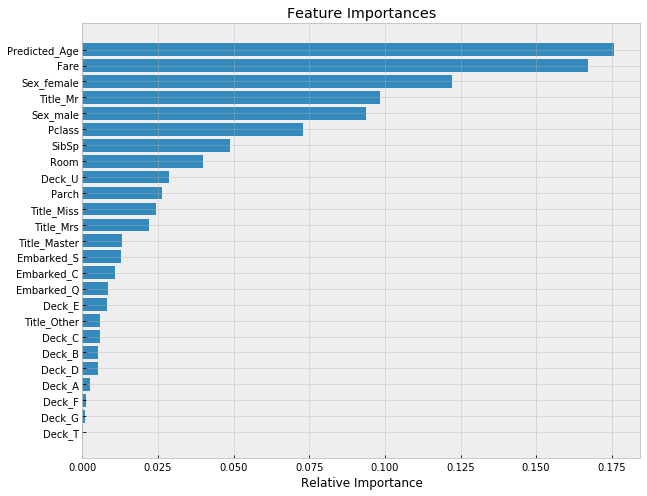

In [13]:
importances = rf_random.best_estimator_.feature_importances_
indices = np.argsort(importances)

fig= plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [valid_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 4.3 Support Vector Machine

In [14]:
survival_svm = SVC(gamma='auto')
survival_svm.fit(train_df[valid_features], train_df['Survived'])
print(survival_svm)
evaluate(survival_svm, test_df[valid_features], test_df['Ground_Truth'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[[186  74]
 [ 57 101]]
True positive:  101
True negative:  186
False positive:  74
False negative:  57
Accuracy = (tp + tn) / (p + n), Accuracy =  0.686603
Precision = tp / (tp + fp), Precision =  0.577143
Recall = tp / (tp + fn), Recall =  0.639241
ROC =  0.677313


In [15]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [5e-06, 1e-05, 3e-05],
                     'C': [4500, 5000, 5500]}]
                    # {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svm_grid = select_params(SVC(), tuned_parameters,
                         train_df[valid_features], train_df['Survived'], 5)
evaluate(svm_grid.best_estimator_, test_df[valid_features], test_df['Ground_Truth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 5000, 'gamma': 1e-05, 'kernel': 'rbf'}

Grid scores on development set:

0.805 (+/-0.040) for {'C': 4500, 'gamma': 5e-06, 'kernel': 'rbf'}
0.825 (+/-0.045) for {'C': 4500, 'gamma': 1e-05, 'kernel': 'rbf'}
0.818 (+/-0.044) for {'C': 4500, 'gamma': 3e-05, 'kernel': 'rbf'}
0.810 (+/-0.036) for {'C': 5000, 'gamma': 5e-06, 'kernel': 'rbf'}
0.827 (+/-0.040) for {'C': 5000, 'gamma': 1e-05, 'kernel': 'rbf'}
0.816 (+/-0.040) for {'C': 5000, 'gamma': 3e-05, 'kernel': 'rbf'}
0.814 (+/-0.035) for {'C': 5500, 'gamma': 5e-06, 'kernel': 'rbf'}
0.827 (+/-0.040) for {'C': 5500, 'gamma': 1e-05, 'kernel': 'rbf'}
0.816 (+/-0.040) for {'C': 5500, 'gamma': 3e-05, 'kernel': 'rbf'}
Elapsed time: 3.8088 seconds

[[209  51]
 [ 44 114]]
True positive:  114
True negative:  209
False positive:  51
False negative:  44
Accuracy = (tp + tn) / (p + n), Accuracy =  0.772727
Precision = tp / (tp + fp), Precision =  0.690909
Reca

## 4.4 XGBoost
### 4.4.1 Build a baseline model with fix learning rate and number of estimators.

In [7]:
survival_xgb = XGBClassifier(learning_rate=0.1,
                             n_estimators=1000,
                             max_depth=5,
                             min_child_weight=1,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=27)
survival_xgb.fit(train_df[valid_features], train_df['Survived'])
print(survival_xgb)
evaluate(survival_xgb, test_df[valid_features], test_df['Ground_Truth'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)
[[195  65]
 [ 51 107]]
True positive:  107
True negative:  195
False positive:  65
False negative:  51
Accuracy = (tp + tn) / (p + n), Accuracy =  0.722488
Precision = tp / (tp + fp), Precision =  0.622093
Recall = tp / (tp + fn), Recall =  0.677215
ROC =  0.713608


### General approach of tuning XGBoost parameters
<ol>
    <li>Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.</li>
    <li>Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.</li>
    <li>Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.</li>
    <li>Lower the learning rate and decide the optimal parameters.</li>
</ol>

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
### 4.4.2 Tune max_depth and min_child_weight

In [13]:
tuned_parameters = {
    "max_depth"        : range(3, 10, 2),
    "min_child_weight" : range(1, 6, 2)
}
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=5,
                          min_child_weight=1,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective= 'binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)
xgb_grid = select_params(model_xgb, tuned_parameters,
                         train_df[valid_features], train_df['Survived'], 5)
evaluate(xgb_grid.best_estimator_, test_df[valid_features], test_df['Ground_Truth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_depth': 7, 'min_child_weight': 3}

Grid scores on development set:

0.829 (+/-0.068) for {'max_depth': 3, 'min_child_weight': 1}
0.828 (+/-0.060) for {'max_depth': 3, 'min_child_weight': 3}
0.825 (+/-0.042) for {'max_depth': 3, 'min_child_weight': 5}
0.832 (+/-0.056) for {'max_depth': 5, 'min_child_weight': 1}
0.833 (+/-0.045) for {'max_depth': 5, 'min_child_weight': 3}
0.834 (+/-0.037) for {'max_depth': 5, 'min_child_weight': 5}
0.829 (+/-0.058) for {'max_depth': 7, 'min_child_weight': 1}
0.841 (+/-0.039) for {'max_depth': 7, 'min_child_weight': 3}
0.833 (+/-0.031) for {'max_depth': 7, 'min_child_weight': 5}
0.828 (+/-0.048) for {'max_depth': 9, 'min_child_weight': 1}
0.841 (+/-0.050) for {'max_depth': 9, 'min_child_weight': 3}
0.825 (+/-0.044) for {'max_depth': 9, 'min_child_weight': 5}
Elapsed time: 7.5728 seconds

[[214  46]
 [ 50 108]]
True positive:  108
True negative:  214
False positive

In [14]:
tuned_parameters = {
    "max_depth"        : [6, 7, 8],
    "min_child_weight" : [2, 3, 4, 5]
}
xgb_grid = select_params(model_xgb, tuned_parameters,
                         train_df[valid_features], train_df['Survived'], 5)
evaluate(xgb_grid.best_estimator_, test_df[valid_features], test_df['Ground_Truth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_depth': 7, 'min_child_weight': 3}

Grid scores on development set:

0.833 (+/-0.051) for {'max_depth': 6, 'min_child_weight': 2}
0.838 (+/-0.050) for {'max_depth': 6, 'min_child_weight': 3}
0.837 (+/-0.029) for {'max_depth': 6, 'min_child_weight': 4}
0.835 (+/-0.040) for {'max_depth': 6, 'min_child_weight': 5}
0.834 (+/-0.051) for {'max_depth': 7, 'min_child_weight': 2}
0.841 (+/-0.039) for {'max_depth': 7, 'min_child_weight': 3}
0.835 (+/-0.039) for {'max_depth': 7, 'min_child_weight': 4}
0.833 (+/-0.031) for {'max_depth': 7, 'min_child_weight': 5}
0.833 (+/-0.053) for {'max_depth': 8, 'min_child_weight': 2}
0.834 (+/-0.052) for {'max_depth': 8, 'min_child_weight': 3}
0.828 (+/-0.043) for {'max_depth': 8, 'min_child_weight': 4}
0.834 (+/-0.026) for {'max_depth': 8, 'min_child_weight': 5}
Elapsed time: 8.6734 seconds

[[214  46]
 [ 50 108]]
True positive:  108
True negative:  214
False positive

### 4.4.3 Tune gamma

In [16]:
tuned_parameters = {
    "gamma"        : [i/10.0 for i in range(0, 5)]
}
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=7,
                          min_child_weight=3,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective= 'binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)
xgb_grid = select_params(model_xgb, tuned_parameters,
                         train_df[valid_features], train_df['Survived'], 5)
evaluate(xgb_grid.best_estimator_, test_df[valid_features], test_df['Ground_Truth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'gamma': 0.0}

Grid scores on development set:

0.841 (+/-0.039) for {'gamma': 0.0}
0.840 (+/-0.044) for {'gamma': 0.1}
0.838 (+/-0.036) for {'gamma': 0.2}
0.837 (+/-0.044) for {'gamma': 0.3}
0.835 (+/-0.043) for {'gamma': 0.4}
Elapsed time: 5.0986 seconds

[[214  46]
 [ 50 108]]
True positive:  108
True negative:  214
False positive:  46
False negative:  50
Accuracy = (tp + tn) / (p + n), Accuracy =  0.770335
Precision = tp / (tp + fp), Precision =  0.701299
Recall = tp / (tp + fn), Recall =  0.683544
ROC =  0.753311


### 4.4.4 Tune subsample and colsample_bytree

In [17]:
tuned_parameters = {
    "subsample"        : [i/10.0 for i in range(6, 10)],
    "colsample_bytree" : [i/10.0 for i in range(6, 10)]
}
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=7,
                          min_child_weight=3,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective= 'binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)
xgb_grid = select_params(model_xgb, tuned_parameters,
                         train_df[valid_features], train_df['Survived'], 5)
evaluate(xgb_grid.best_estimator_, test_df[valid_features], test_df['Ground_Truth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'colsample_bytree': 0.8, 'subsample': 0.8}

Grid scores on development set:

0.829 (+/-0.066) for {'colsample_bytree': 0.6, 'subsample': 0.6}
0.825 (+/-0.052) for {'colsample_bytree': 0.6, 'subsample': 0.7}
0.836 (+/-0.061) for {'colsample_bytree': 0.6, 'subsample': 0.8}
0.826 (+/-0.056) for {'colsample_bytree': 0.6, 'subsample': 0.9}
0.837 (+/-0.055) for {'colsample_bytree': 0.7, 'subsample': 0.6}
0.836 (+/-0.049) for {'colsample_bytree': 0.7, 'subsample': 0.7}
0.837 (+/-0.059) for {'colsample_bytree': 0.7, 'subsample': 0.8}
0.827 (+/-0.066) for {'colsample_bytree': 0.7, 'subsample': 0.9}
0.825 (+/-0.046) for {'colsample_bytree': 0.8, 'subsample': 0.6}
0.838 (+/-0.054) for {'colsample_bytree': 0.8, 'subsample': 0.7}
0.841 (+/-0.039) for {'colsample_bytree': 0.8, 'subsample': 0.8}
0.833 (+/-0.053) for {'colsample_bytree': 0.8, 'subsample': 0.9}
0.826 (+/-0.050) for {'colsample_bytree': 0.9, 'subsamp

In [18]:
tuned_parameters = {
    "subsample"        : [i/100.0 for i in range(75, 90, 5)],
    "colsample_bytree" : [i/100.0 for i in range(75, 90, 5)]
}
xgb_grid = select_params(model_xgb, tuned_parameters,
                         train_df[valid_features], train_df['Survived'], 5)
evaluate(xgb_grid.best_estimator_, test_df[valid_features], test_df['Ground_Truth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'colsample_bytree': 0.8, 'subsample': 0.8}

Grid scores on development set:

0.835 (+/-0.054) for {'colsample_bytree': 0.75, 'subsample': 0.75}
0.834 (+/-0.049) for {'colsample_bytree': 0.75, 'subsample': 0.8}
0.836 (+/-0.056) for {'colsample_bytree': 0.75, 'subsample': 0.85}
0.836 (+/-0.035) for {'colsample_bytree': 0.8, 'subsample': 0.75}
0.841 (+/-0.039) for {'colsample_bytree': 0.8, 'subsample': 0.8}
0.832 (+/-0.049) for {'colsample_bytree': 0.8, 'subsample': 0.85}
0.834 (+/-0.050) for {'colsample_bytree': 0.85, 'subsample': 0.75}
0.836 (+/-0.036) for {'colsample_bytree': 0.85, 'subsample': 0.8}
0.833 (+/-0.041) for {'colsample_bytree': 0.85, 'subsample': 0.85}
Elapsed time: 8.6592 seconds

[[214  46]
 [ 50 108]]
True positive:  108
True negative:  214
False positive:  46
False negative:  50
Accuracy = (tp + tn) / (p + n), Accuracy =  0.770335
Precision = tp / (tp + fp), Precision =  0.701299
Re

### 4.4.5 Tune Regularization Parameters

In [22]:
tuned_parameters = {
    "reg_alpha" : [1e-5, 1e-2, 0.1, 1, 100],
    "reg_lambda" : [1e-5, 1e-2, 0.1, 1, 100],
}
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=7,
                          min_child_weight=3,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective= 'binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27).fit()
xgb_grid = select_params(model_xgb, tuned_parameters,
                         train_df[valid_features], train_df['Survived'], 5)
evaluate(xgb_grid.best_estimator_, test_df[valid_features], test_df['Ground_Truth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'reg_alpha': 1e-05, 'reg_lambda': 1}

Grid scores on development set:

0.831 (+/-0.052) for {'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
0.835 (+/-0.046) for {'reg_alpha': 1e-05, 'reg_lambda': 0.01}
0.835 (+/-0.064) for {'reg_alpha': 1e-05, 'reg_lambda': 0.1}
0.841 (+/-0.039) for {'reg_alpha': 1e-05, 'reg_lambda': 1}
0.813 (+/-0.039) for {'reg_alpha': 1e-05, 'reg_lambda': 100}
0.829 (+/-0.054) for {'reg_alpha': 0.01, 'reg_lambda': 1e-05}
0.828 (+/-0.045) for {'reg_alpha': 0.01, 'reg_lambda': 0.01}
0.832 (+/-0.048) for {'reg_alpha': 0.01, 'reg_lambda': 0.1}
0.833 (+/-0.051) for {'reg_alpha': 0.01, 'reg_lambda': 1}
0.814 (+/-0.040) for {'reg_alpha': 0.01, 'reg_lambda': 100}
0.837 (+/-0.042) for {'reg_alpha': 0.1, 'reg_lambda': 1e-05}
0.828 (+/-0.047) for {'reg_alpha': 0.1, 'reg_lambda': 0.01}
0.836 (+/-0.046) for {'reg_alpha': 0.1, 'reg_lambda': 0.1}
0.838 (+/-0.040) for {'reg_alpha': 0.1, 'reg_lambda': 

### 4.4.6 Reduce learning rate

In [24]:
optimal_xgb = XGBClassifier(learning_rate=0.01,
                            n_estimators=5000,
                            max_depth=7,
                            min_child_weight=3,
                            gamma=0,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            objective= 'binary:logistic',
                            nthread=4,
                            scale_pos_weight=1,
                            seed=27).fit(train_df[valid_features], train_df['Survived'])
evaluate(optimal_xgb, test_df[valid_features], test_df['Ground_Truth'])

[[207  53]
 [ 52 106]]
True positive:  106
True negative:  207
False positive:  53
False negative:  52
Accuracy = (tp + tn) / (p + n), Accuracy =  0.748804
Precision = tp / (tp + fp), Precision =  0.666667
Recall = tp / (tp + fn), Recall =  0.670886
ROC =  0.73352


# References
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
    
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://medium.com/@praveen.orvakanti/this-will-help-you-score-95-percentile-in-the-kaggle-titanic-ml-competition-aa2b3fd1b79b